In [1]:
%load_ext autoreload
%autoreload 2
import requests
import os
import pandas as pd
import dgl.function as fn
import matplotlib.pyplot as plt

import numpy as np

# from modules.gnn import GNN
import scipy.sparse as sp
import numpy as np
import os

from modules.graph import Graph
from utils import month_name_to_number, month_number_to_name

import torch
import torch.nn.functional as F


# Descargar archivo PeeringDB



## Información general

- `asn`: Número de Sistema Autónomo.
- `name`: Nombre corto de la red u organización.
- `name_long`: Nombre largo o completo de la organización.
- `aka`: Otros nombres por los que se conoce a la organización (alias).
- `org_id`: ID de la organización dentro de PeeringDB.
- `website`: Sitio web.
- `notes`: Notas adicionales públicas que la red haya dejado.



## Infraestructura de red

- `fac_count`: Número de datacenters (facilidades) donde opera.
- `ix_count`: Número de IXPs (puntos de intercambio de tráfico) en los que participa.
- `netfac_updated`: Fecha de última actualización de datos en facilidades.
- `netixlan_updated`: Fecha de última actualización de datos en IXPs.



## Políticas de peering

- `policy_general`: Política de peering. Valores típicos: `Open`, `Selective`, `Restrictive`, `No` (a veces vacío `''`).
- `policy_ratio`: Si el ratio de tráfico influye en la aceptación de peering (`True/False`).
- `policy_locations`: Dónde aplica la política. Ejemplos: `Required - US`, `Preferred`, `Required - EU`, `Required - International`, `Not Required` (a veces vacío `''`).
- `policy_contracts`: Si se requiere contrato. Ejemplos: `Private Only`, `Not Required`, `Required` (a veces vacío `''`).
- `policy_url`: URL pública donde se detalla la política de peering.



## Capacidad y tipo de tráfico

- `info_prefixes4`: Cantidad de prefijos IPv4 anunciados.
- `info_prefixes6`: Cantidad de prefijos IPv6 anunciados.
- `info_traffic`: Nivel estimado de tráfico (ej.: `100-200Gbps`, `20Gbps`, etc.).
- `info_unicast`: Soporta tráfico unicast (`True/False`).
- `info_multicast`: Soporta tráfico multicast (`True/False`).
- `info_ipv6`: Soporta tráfico IPv6 (`True/False`).
- `info_scope`: Alcance de la red (ej.: `Global`, `Regional`, `National`, etc.).
- `info_type`: Tipo de red (ej.: `NSP`, `Content`, `Enterprise`, etc.).
- `info_never_via_route_servers`: Indica si no acepta rutas vía route servers (`True/False`).
- `info_ratio`: Perfil de tráfico (ej.: `Balanced`, `Mostly Inbound`, `Mostly Outbound`, etc.; a veces vacío `''`).



## Monitoreo y herramientas

- `route_server`: (campo relacionado con route servers; puede venir vacío).
- `looking_glass`: URL del looking glass (para ver rutas anunciadas/recibidas).
- `status_dashboard`: Página de estado de la red (incidentes, mantenimientos, etc.).



## Tiempos y actualizaciones

- `created`: Fecha de creación del registro en PeeringDB.
- `updated`: Última fecha de actualización del registro general.
- `poc_updated`: Última vez que se actualizaron los contactos (Points of Contact).
- `id`: Identificador interno del registro.
- `allow_ixp_update`: Indica si los IXPs pueden actualizar la información de esta red.
- `irr_as_set`: Set de objetos IRR (Internet Routing Registry) usados para filtrado de rutas.


#### Funciones Auxiliares

In [2]:
def dowload_peeringdb(year:str, month:str, day:str, output_dir:str='data/peeringdb/'):
    """
    Download the latest PeeringDB data from the official website.
    """

    # URL de descarga de PeeringDB data en caida
    url = f"https://publicdata.caida.org/datasets/peeringdb/{year}/{month}/peeringdb_2_dump_{year}_{month}_{day}.json"

    # Carpeta donde se guarda el archivo
    file_path = os.path.join(output_dir, f"peeringdb_{year}_{month_number_to_name(month)}_{day}.json")

    # Descargar el archivo
    try:
        response = requests.get(url)
    except:
        print(f"Error downloading PeeringDB data: {e}")
        return

    with open(file_path, "wb") as file:
        file.write(response.content)

    print(f"Downloaded PeeringDB data to {file_path}")
    return file_path

#### Descarga Archivo PeeringDB

In [ ]:
# ANO = '2024'
# MES = 'enero'
# DIA = '01'

# DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'
# OUTPUT_DIR = DATA_PATH + 'peeringdb/'
# peeringdb_file_path = dowload_peeringdb(ANO, month_name_to_number(MES), DIA, OUTPUT_DIR)

# 8 min

Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_enero_01.json


In [4]:
DATA_PATH = '/media/valentina/KINGSTON/TESIS/data/'
OUTPUT_DIR = DATA_PATH + 'peeringdb/json/'

In [ ]:
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
DIA = '01'

archivos_peeringdb = []

for mes in meses:
    print(f'Descargando PeeringDB de {mes}...')
    peeringdb_file_path = dowload_peeringdb(ANO, month_name_to_number(mes), DIA, OUTPUT_DIR)




Descargando PeeringDB de enero...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_enero_01.json
Descargando PeeringDB de febrero...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_febrero_01.json
Descargando PeeringDB de marzo...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_marzo_01.json
Descargando PeeringDB de abril...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_abril_01.json
Descargando PeeringDB de mayo...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_mayo_01.json
Descargando PeeringDB de junio...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_junio_01.json
Descargando PeeringDB de julio...
Downloaded PeeringDB data to /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_2024_julio_01.json
Descargando PeeringDB de 

In [5]:
# Listar todos los archivos del directorio que empiezan con "peeringdb_"
# ---------------------------------
import json

archivos_peeringdb = [
    os.path.join(OUTPUT_DIR, f) 
    for f in os.listdir(OUTPUT_DIR) 
    if f.startswith('peeringdb_') and f.endswith('.json')
]

print(f"[CANTIDAD ARCHIVOS]: {len(archivos_peeringdb)} ")

# Abrir y procesar cada archivo
# ---------------------------------
for archivo in archivos_peeringdb:
    print(f"\nProcesando: {os.path.basename(archivo)}")
    
    
    with open(archivo) as f:
        data = json.load(f)
        num_networks = len(data['net']['data'])
        print(f"  Número de redes: {num_networks}")

[CANTIDAD ARCHIVOS]: 12 

Procesando: peeringdb_2024_abril_01.json
  Número de redes: 29942

Procesando: peeringdb_2024_agosto_01.json
  Número de redes: 31052

Procesando: peeringdb_2024_diciembre_01.json
  Número de redes: 31425

Procesando: peeringdb_2024_enero_01.json
  Número de redes: 29150

Procesando: peeringdb_2024_febrero_01.json
  Número de redes: 29418

Procesando: peeringdb_2024_julio_01.json
  Número de redes: 30744

Procesando: peeringdb_2024_junio_01.json
  Número de redes: 30504

Procesando: peeringdb_2024_marzo_01.json
  Número de redes: 29656

Procesando: peeringdb_2024_mayo_01.json
  Número de redes: 30242

Procesando: peeringdb_2024_noviembre_01.json
  Número de redes: 31295

Procesando: peeringdb_2024_octubre_01.json
  Número de redes: 31094

Procesando: peeringdb_2024_septiembre_01.json
  Número de redes: 31274


In [ ]:
# import json

# with open(peeringdb_file_path) as f:
#     data = json.load(f)['net']['data']
#     first_as = data[0]
#     print("Llaves ASN:")
#     for key in first_as.keys():
#         print(f"  * {key}: {type(first_as[key])}")

Llaves ASN:
  * id: <class 'int'>
  * org_id: <class 'int'>
  * name: <class 'str'>
  * aka: <class 'str'>
  * name_long: <class 'str'>
  * website: <class 'str'>
  * social_media: <class 'list'>
  * asn: <class 'int'>
  * looking_glass: <class 'str'>
  * route_server: <class 'str'>
  * irr_as_set: <class 'str'>
  * info_type: <class 'str'>
  * info_types: <class 'list'>
  * info_prefixes4: <class 'int'>
  * info_prefixes6: <class 'int'>
  * info_traffic: <class 'str'>
  * info_ratio: <class 'str'>
  * info_scope: <class 'str'>
  * info_unicast: <class 'bool'>
  * info_multicast: <class 'bool'>
  * info_ipv6: <class 'bool'>
  * info_never_via_route_servers: <class 'bool'>
  * ix_count: <class 'int'>
  * fac_count: <class 'int'>
  * notes: <class 'str'>
  * netixlan_updated: <class 'str'>
  * netfac_updated: <class 'str'>
  * poc_updated: <class 'str'>
  * policy_url: <class 'str'>
  * policy_general: <class 'str'>
  * policy_locations: <class 'str'>
  * policy_ratio: <class 'bool'>
  *

#### Creación Diccionario Para cada Mes

Diccionario indica si el atributo es :
* Categorico: transforma en un one-hot vector
* Numerico: Normaliza y naja desviacion


In [6]:
# Listas con los nombres de los atributos que nos interesan
# ---------------------------------
num_list = ['ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']
categorical_list = ['policy_general', 'policy_locations', 'policy_contracts', 'info_traffic', 'info_scope', 'info_type', 'info_ratio']
boolean_list = ['policy_ratio', 'info_unicast', 'info_multicast', 'info_ipv6', 'info_never_via_route_servers']

Extraer todas las categorías únicas de todos los archivos

In [8]:
# Diccionario para almacenar todas las categorías únicas encontradas en TODOS los archivos
all_categories = {attr: set() for attr in categorical_list}

print("Escaneando todos los archivos para encontrar todas las categorías únicas...")

# Recorrer todos los archivos para encontrar todas las categorías posibles
for archivo in archivos_peeringdb:
    print(f"  Escaneando: {os.path.basename(archivo)}")
    
    with open(archivo) as f:
        data = json.load(f)['net']['data']
        
        # Para cada atributo categórico
        for attr in categorical_list:
            # Agregar todos los valores únicos encontrados
            for asn in data:
                value = asn.get(attr)
                # Convertir None o '' a un valor estándar
                if value is None or value == '':
                    value = 'Sin dato'
                all_categories[attr].add(value)

# Mostrar resumen
print("\n=== RESUMEN DE CATEGORÍAS ENCONTRADAS ===")
for attr, categories in all_categories.items():
    print(f"{attr}: {len(categories)} categorías únicas\n--------------------------")
    print(f"  {sorted(categories)}\n")

Escaneando todos los archivos para encontrar todas las categorías únicas...
  Escaneando: peeringdb_2024_abril_01.json
  Escaneando: peeringdb_2024_agosto_01.json
  Escaneando: peeringdb_2024_diciembre_01.json
  Escaneando: peeringdb_2024_enero_01.json
  Escaneando: peeringdb_2024_febrero_01.json
  Escaneando: peeringdb_2024_julio_01.json
  Escaneando: peeringdb_2024_junio_01.json
  Escaneando: peeringdb_2024_marzo_01.json
  Escaneando: peeringdb_2024_mayo_01.json
  Escaneando: peeringdb_2024_noviembre_01.json
  Escaneando: peeringdb_2024_octubre_01.json
  Escaneando: peeringdb_2024_septiembre_01.json

=== RESUMEN DE CATEGORÍAS ENCONTRADAS ===
policy_general: 5 categorías únicas
--------------------------
  ['No', 'Open', 'Restrictive', 'Selective', 'Sin dato']

policy_locations: 6 categorías únicas
--------------------------
  ['Not Required', 'Preferred', 'Required - EU', 'Required - International', 'Required - US', 'Sin dato']

policy_contracts: 4 categorías únicas
-----------------

Función para procesar cada archivo con categorías consistentes

In [7]:
def process_peeringdb_file(archivo, all_categories, num_list, categorical_list):
    """
    Recibe un archivo json de PeeringDB y crea un DataFrame con atributos numéricos y categóricos.
    """
    print(f"\nProcesando: {os.path.basename(archivo)}")
    
    # 1.- Cargar datos
    # ---------------------------------
    with open(archivo) as f:
        data = json.load(f)['net']['data']
    
    # 2.- Procesar atributos numéricos
    # ---------------------------------
    num_list_with_asn = ['asn'] + num_list
    num_data = {attr: [asn.get(attr, None) for asn in data] for attr in num_list_with_asn}
    num_df = pd.DataFrame(num_data)
    
    # 3.- Transformación logarítmica y normalización
    # ---------------------------------
    num_df[num_list] = num_df[num_list].astype(float)
    num_df[num_list] = num_df[num_list].apply(lambda x: np.log(x + 1))
    num_df[num_list] = num_df[num_list].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # 4.- Procesar atributos categóricos con categorías predefinidas
    # ---------------------------------
    cat_data = {attr: [asn.get(attr, None) for asn in data] for attr in categorical_list}
    cat_df = pd.DataFrame(cat_data)
    
    # 5.- Reemplazar None y '' con 'Sin dato'
    # ---------------------------------
    cat_df = cat_df.fillna('Sin dato')
    cat_df = cat_df.replace('', 'Sin dato')
    
    # 6.- One-hot encoding con categorías predefinidas
    # ---------------------------------
    cat_df_encoded = pd.get_dummies(cat_df, columns=categorical_list, prefix=categorical_list, dtype=int)
    
    # 7.- Crear todas las columnas posibles basadas en all_categories
    for attr in categorical_list:
        for category in all_categories[attr]:
            col_name = f"{attr}_{category}"
            if col_name not in cat_df_encoded.columns:
                cat_df_encoded[col_name] = 0  # Agregar columna faltante con ceros
    
    # 8.- Ordenar columnas alfabéticamente para consistencia
    cat_df_encoded = cat_df_encoded.reindex(sorted(cat_df_encoded.columns), axis=1)
    
    # 9.- Combinar DataFrames
    final_df = pd.concat([num_df, cat_df_encoded], axis=1)
    final_df = final_df.rename(columns={'asn': 'ASN'})
    final_df = final_df.sort_values(by='ASN', ascending=True).reset_index(drop=True)
    
    print(f"  Forma del DataFrame: {final_df.shape}")
    print(f"  Número de redes: {len(final_df)}")
    
    return final_df

Procesar todos los archivos y guardar los CSV

In [ ]:
dataframes = []  # Lista para almacenar todos los DataFrames si quieres compararlos

for archivo in archivos_peeringdb:
    # 1.- Crea DF a partir de .json de peeringdb
    # ---------------------------------
    df = process_peeringdb_file(archivo, all_categories, num_list, categorical_list)

    # 2.- Guardar el DataFrame como .csv
    # --------------------------------
    ano = archivo.split('_')[1]
    mes = archivo.split('_')[2]
    output_filename = DATA_PATH + f'peeringdb/attr/peeringdb_as_attr_{ano}_{mes}.csv'

    df.to_csv(output_filename, index=False)
    print(f"Guardado en: {output_filename}\n")

    dataframes.append(df)

# Verificar que todos tengan el mismo número de columnas
print("\n VERIFICACIÓN FINAL \n --------------")
shapes = [df.shape for df in dataframes]
print(f"Formas de todos los DataFrames: {shapes}")
print(f"¿Todos tienen el mismo número de columnas? {len(set([s[1] for s in shapes])) == 1}")
print(f"Número de columnas: {dataframes[0].shape[1]}")


Procesando: peeringdb_2024_septiembre_01.json
  Forma del DataFrame: (31274, 69)
  Número de redes: 31274
Guardado en: /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_as_attr_2024_septiembre.csv


Procesando: peeringdb_2024_octubre_01.json
  Forma del DataFrame: (31094, 69)
  Número de redes: 31094
Guardado en: /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_as_attr_2024_octubre.csv


Procesando: peeringdb_2024_noviembre_01.json
  Forma del DataFrame: (31295, 69)
  Número de redes: 31295
Guardado en: /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_as_attr_2024_noviembre.csv


Procesando: peeringdb_2024_diciembre_01.json
  Forma del DataFrame: (31425, 69)
  Número de redes: 31425
Guardado en: /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_as_attr_2024_diciembre.csv


Procesando: peeringdb_2024_enero_01.json
  Forma del DataFrame: (29150, 69)
  Número de redes: 29150
Guardado en: /media/valentina/KINGSTON/TESIS/data/peeringdb/peeringdb_as_attr_2024_e

### Atributos Numericos



Atributos Númericos a ocupar:
* asn: Número de Sistema Autónomo
* ix_count: Cantidad ...
* fac_count: Cantidad ...
* info_prefixes4: Cantidad ...
* info_prefixes6: Cantidad ...

In [9]:
num_list = ['asn', 'ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']


# Crear DataFrame con los datos numéricos
num_data = {attr: [asn.get(attr, None) for asn in data] for attr in num_list}
num_df = pd.DataFrame(num_data)

# Logarithmic transformation to decrease their variability,
num_df[num_list[1:]] = num_df[num_list[1:]].astype(float)
num_df[num_list[1:]] = num_df[num_list[1:]].apply(lambda x: np.log(x + 1))

# Normalization
num_df[num_list[1:]] = num_df[num_list[1:]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

num_df

,asn,ix_count,fac_count,info_prefixes4,info_prefixes6
0,4436,0.000000,0.000000,0.883505,0.730318
1,20940,0.930249,0.792907,0.679870,0.675365
2,31800,0.480658,0.000000,0.079520,0.000000
3,3303,0.709798,0.519147,0.666674,0.594384
4,22773,0.000000,0.405650,0.666674,0.634871
...,...,...,...,...,...
31269,151012,0.120164,0.164566,0.079520,0.000000
31270,37740,0.000000,0.164566,0.000000,0.000000
31271,11097,0.120164,0.000000,0.100343,0.154296
31272,207638,0.120164,0.000000,0.079520,0.087112


In [10]:

for colum in num_df.columns:
    min = num_df[colum].min()
    max = num_df[colum].max()
    print(f"Columna: {colum} Min: {min} Max: {max}") 

Columna: asn Min: 3 Max: 401308
Columna: ix_count Min: 0.0 Max: 1.0
Columna: fac_count Min: 0.0 Max: 1.0
Columna: info_prefixes4 Min: 0.0 Max: 1.0
Columna: info_prefixes6 Min: 0.0 Max: 1.0


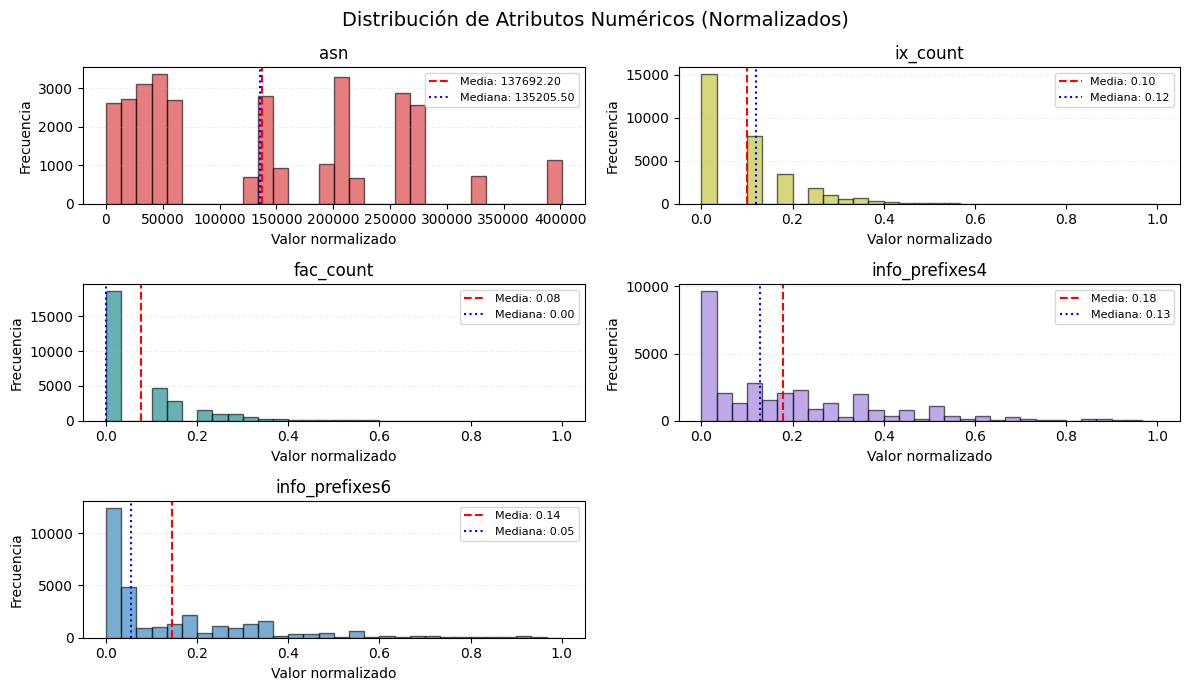

In [12]:
# Ahora graficamos usando subplots (estilo como la imagen)
cols = list(num_df.columns)
n = len(cols)

ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 7))
axs = np.array(axs).reshape(-1)  # flatten siempre

colors = ["tab:red", "tab:olive", "teal", "mediumpurple", "tab:blue", "tab:orange"]

for i, col in enumerate(cols):
    ax = axs[i]
    values = num_df[col].dropna().astype(float).values
    color = colors[i % len(colors)]

    ax.hist(values, bins=30, edgecolor="black", alpha=0.6, color=color)

    mean_val = float(np.mean(values)) if len(values) else float("nan")
    median_val = float(np.median(values)) if len(values) else float("nan")

    ax.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Media: {mean_val:.2f}")
    ax.axvline(median_val, color="blue", linestyle=":", linewidth=1.5, label=f"Mediana: {median_val:.2f}")

    ax.set_title(col)
    ax.set_xlabel("Valor normalizado")
    ax.set_ylabel("Frecuencia")
    ax.grid(axis="y", alpha=0.2, linestyle="--")
    ax.legend(loc="upper right", fontsize=8)

# Ocultar ejes sobrantes (si n no llena la grilla)
for j in range(n, len(axs)):
    axs[j].axis("off")

fig.suptitle("Distribución de Atributos Numéricos (Normalizados)", fontsize=14)
plt.tight_layout()
plt.show()

## Atributos Categoricos

In [13]:
categorical_list = ['policy_general', 'policy_locations', 'policy_contracts', 'info_traffic', 'info_scope', 'info_type', 'info_ratio']


# Listas de atributos
boolean_list = ['policy_ratio', 'info_unicast', 'info_multicast', 'info_ipv6', 'info_never_via_route_servers']
list_all = num_list + categorical_list + boolean_list


# Crear DataFrame con los datos categóricos y hacer one-hot encoding
cat_data = {attr: [asn.get(attr, None) for asn in data] for attr in categorical_list}
cat_df = pd.DataFrame(cat_data)

# Realizar One-Hot Encoding para los atributos categóricos
cat_df_encoded = pd.get_dummies(cat_df, columns=categorical_list, prefix=categorical_list,dtype=int)
cat_df_encoded


,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,policy_locations_,policy_locations_Not Required,policy_locations_Preferred,policy_locations_Required - EU,policy_locations_Required - International,...,info_type_Non-Profit,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31269,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
31270,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31271,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
31272,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
for attr in categorical_list:
    unique_vals = cat_df[attr].unique()
    print(f"Atributo: {attr}")
    print(f"Categorías únicas ({len(unique_vals)}): {unique_vals}\n")


Atributo: policy_general
Categorías únicas (5): ['Restrictive' 'Open' 'Selective' 'No' '']

Atributo: policy_locations
Categorías únicas (6): ['Required - International' 'Not Required' 'Preferred' 'Required - US' ''
 'Required - EU']

Atributo: policy_contracts
Categorías únicas (4): ['Required' 'Not Required' 'Private Only' '']

Atributo: info_traffic
Categorías únicas (19): ['' '100+Tbps' '100-1000Mbps' '1-5Tbps' '100-200Gbps' '10-20Gbps'
 '500-1000Gbps' '20-50Gbps' '0-20Mbps' '10-20Tbps' '1-5Gbps' '20-100Mbps'
 '300-500Gbps' '5-10Tbps' '50-100Gbps' '200-300Gbps' '5-10Gbps'
 '50-100Tbps' '20-50Tbps']

Atributo: info_scope
Categorías únicas (11): ['Global' 'Europe' 'North America' 'Regional' 'Asia Pacific'
 'South America' '' 'Not Disclosed' 'Australia' 'Middle East' 'Africa']

Atributo: info_type
Categorías únicas (11): ['NSP' 'Content' 'Non-Profit' 'Cable/DSL/ISP' '' 'Educational/Research'
 'Network Services' 'Enterprise' 'Route Server' 'Route Collector'
 'Government']

Atributo: in

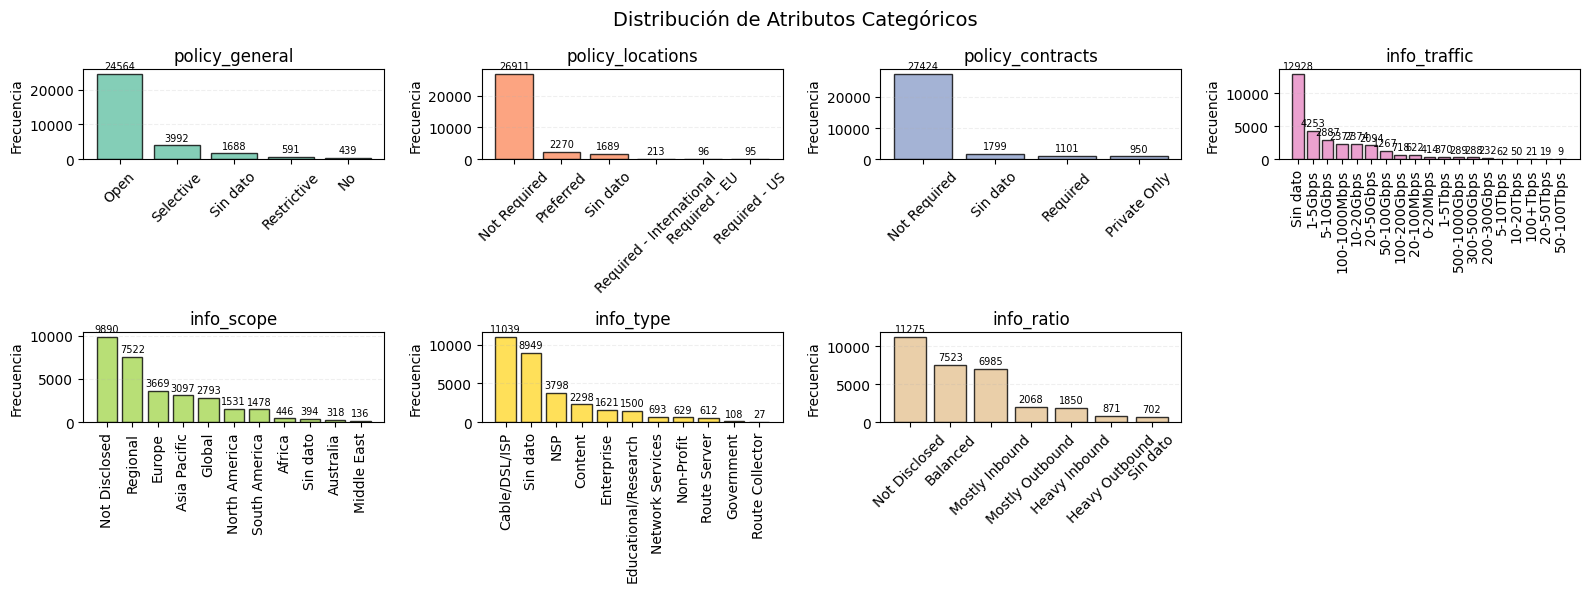

In [15]:
# Ahora graficamos los atributos categóricos (estilo como la imagen)
attrs = list(categorical_list)
n = len(attrs)

ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6))
axs = np.array(axs).reshape(-1)  # flatten

colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

def _clean_category(x):
    if x is None or (isinstance(x, float) and np.isnan(x)) or x == "":
        return "Sin dato"
    return str(x)

for i, attr in enumerate(attrs):
    ax = axs[i]
    series = cat_df[attr].map(_clean_category)
    value_counts = series.value_counts(dropna=False)
    color = colors[i % len(colors)]

    bars = ax.bar(value_counts.index.astype(str), value_counts.values, edgecolor="black", alpha=0.8, color=color)
    ax.set_title(attr)
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")
    ax.grid(axis="y", alpha=0.2, linestyle="--")

    # Rotación dinámica según cantidad de categorías
    rotation = 90 if len(value_counts) > 8 else 45
    ax.tick_params(axis="x", rotation=rotation)

    # Etiquetas con el conteo arriba de cada barra
    ax.bar_label(bars, labels=[str(v) for v in value_counts.values], padding=2, fontsize=7, rotation=0)

# Ocultar ejes sobrantes
for j in range(n, len(axs)):
    axs[j].axis("off")

fig.suptitle("Distribución de Atributos Categóricos", fontsize=14)
plt.tight_layout()
plt.show()